In [2]:
import pandas as pd
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import subprocess
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
csv_path = Path("trm_to_rn.csv")

df = pd.read_csv(
    csv_path,
    encoding="latin-1",   # ajusta si cambia
    sep=None,             # autodetecta delimitador
    engine="python",      # necesario para sep=None
    on_bad_lines="skip"   # descarta líneas mal formadas
)

print(df.head())


   periodo     trm        dia primera_dif segunda_dif trans_max_min  \
0    33569  693,32  miércoles         NaN         NaN           NaN   
1    33570  693,99     jueves        0,67         NaN   0,415723422   
2    33571   694,7    viernes        0,71        1,38   0,415830457   
3    33574  643,42      lunes      -51,28      -50,57   0,276711889   
4    33575  639,22     martes        -4,2      -55,48   0,402691927   

  estanrazicacion z trans_max_min.1          1dif     y_t   y_t-1 y_t-2 y_t-3  \
0               NaN     0,016371698           NaN     NaN     NaN   NaN   NaN   
1       0,016440259     0,016522579   0,000150881    0,67     NaN   NaN   NaN   
2       0,018529611     0,016682468   0,000159889    0,71    0,67   NaN   NaN   
3      -2,697105727     0,005134453  -0,011548015  -51,28    0,71  0,67   NaN   
4      -0,237938354     0,004188633   -0,00094582    -4,2  -51,28  0,71  0,67   

        m1            m2   m3  
0      NaN           NaN  NaN  
1      NaN           N

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8857 entries, 0 to 8856
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   periodo            8857 non-null   int64 
 1   trm                8857 non-null   object
 2   dia                8857 non-null   object
 3   primera_dif        8856 non-null   object
 4   segunda_dif        8855 non-null   object
 5   trans_max_min      8856 non-null   object
 6   estanrazicacion z  8856 non-null   object
 7   trans_max_min.1    8857 non-null   object
 8   1dif               8856 non-null   object
 9   y_t                8856 non-null   object
 10  y_t-1              8855 non-null   object
 11  y_t-2              8854 non-null   object
 12  y_t-3              8853 non-null   object
 13  m1                 8854 non-null   object
 14  m2                 8853 non-null   object
 15  m3                 8852 non-null   object
dtypes: int64(1), object(15)
memory usage: 1.1+

In [5]:
# Paso 1: Inspección inicial
print("=" * 50)
print("PASO 1: INSPECCIÓN INICIAL")
print("=" * 50)

# Ver forma del dataset
print(f"\nDimensiones: {df.shape}")
print(f"Filas: {df.shape[0]}, Columnas: {df.shape[1]}")

PASO 1: INSPECCIÓN INICIAL

Dimensiones: (8857, 16)
Filas: 8857, Columnas: 16


In [6]:
print("\nPrimeras 5 filas:")
print(df.head())


Primeras 5 filas:
   periodo     trm        dia primera_dif segunda_dif trans_max_min  \
0    33569  693,32  miércoles         NaN         NaN           NaN   
1    33570  693,99     jueves        0,67         NaN   0,415723422   
2    33571   694,7    viernes        0,71        1,38   0,415830457   
3    33574  643,42      lunes      -51,28      -50,57   0,276711889   
4    33575  639,22     martes        -4,2      -55,48   0,402691927   

  estanrazicacion z trans_max_min.1          1dif     y_t   y_t-1 y_t-2 y_t-3  \
0               NaN     0,016371698           NaN     NaN     NaN   NaN   NaN   
1       0,016440259     0,016522579   0,000150881    0,67     NaN   NaN   NaN   
2       0,018529611     0,016682468   0,000159889    0,71    0,67   NaN   NaN   
3      -2,697105727     0,005134453  -0,011548015  -51,28    0,71  0,67   NaN   
4      -0,237938354     0,004188633   -0,00094582    -4,2  -51,28  0,71  0,67   

        m1            m2   m3  
0      NaN           NaN  NaN  
1  

In [7]:
# Ver últimas filas
print("\nÚltimas 5 filas:")
print(df.tail())


Últimas 5 filas:
      periodo      trm        dia primera_dif segunda_dif trans_max_min  \
8852    45961  3870,42    viernes      -14,87       -4,42   0,374140376   
8853    45964  3860,12      lunes       -10,3      -25,17    0,38636911   
8854    45965  3860,12     martes           0       -10,3   0,413930588   
8855    45966  3872,47  miércoles       12,35       12,35   0,446977603   
8856    45967  3839,47     jueves         -33      -20,65   0,325626823   

     estanrazicacion z trans_max_min.1          1dif     y_t   y_t-1   y_t-2  \
8852      -0,795273016     0,731839688  -0,003348654  -14,87   10,45   30,64   
8853      -0,556564543     0,729520176  -0,002319512   -10,3  -14,87   10,45   
8854      -0,018556388     0,729520176             0       0   -10,3  -14,87   
8855        0,62653106     0,732301338   0,002781162   12,35       0   -10,3   
8856      -1,742271837     0,724869893  -0,007431445     -33   12,35       0   

       y_t-3       m1            m2       m3  
885

In [8]:
print("\nInformación del dataset:")
print(df.info())


Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8857 entries, 0 to 8856
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   periodo            8857 non-null   int64 
 1   trm                8857 non-null   object
 2   dia                8857 non-null   object
 3   primera_dif        8856 non-null   object
 4   segunda_dif        8855 non-null   object
 5   trans_max_min      8856 non-null   object
 6   estanrazicacion z  8856 non-null   object
 7   trans_max_min.1    8857 non-null   object
 8   1dif               8856 non-null   object
 9   y_t                8856 non-null   object
 10  y_t-1              8855 non-null   object
 11  y_t-2              8854 non-null   object
 12  y_t-3              8853 non-null   object
 13  m1                 8854 non-null   object
 14  m2                 8853 non-null   object
 15  m3                 8852 non-null   object
dtypes: int64(1), obj

In [9]:
# Valores nulos por columna
print("\nValores nulos:")
print(df.isnull().sum())


Valores nulos:
periodo              0
trm                  0
dia                  0
primera_dif          1
segunda_dif          2
trans_max_min        1
estanrazicacion z    1
trans_max_min.1      0
1dif                 1
y_t                  1
y_t-1                2
y_t-2                3
y_t-3                4
m1                   3
m2                   4
m3                   5
dtype: int64


In [10]:
columnas_numericas = [
    'trm', 'primera_dif', 'segunda_dif', 'trans_max_min', 
    'estanrazicacion z', 'trans_max_min.1', '1dif', 'y_t', 
    'y_t-1', 'y_t-2', 'y_t-3', 'm1', 'm2', 'm3'
]

def convertir_europeo_a_numero(valor):
    if pd.isna(valor):
        return None
    # Convertir a string y reemplazar coma por punto
    return float(str(valor).replace(',', '.'))

# Convertir cada columna numérica
for col in columnas_numericas:
    if col in df.columns:
        try:
            df[col] = df[col].apply(convertir_europeo_a_numero)
            print(f" {col}: convertida a numérico (formato europeo)")
        except Exception as e:
            print(f" {col}: error en conversión - {e}")

print("\nNuevos tipos de datos:")
print(df.dtypes)

# Verificar conversión exitosa
print("\nValores no nulos por columna:")
print(df[columnas_numericas].count())

 trm: convertida a numérico (formato europeo)
 primera_dif: convertida a numérico (formato europeo)
 segunda_dif: convertida a numérico (formato europeo)
 trans_max_min: convertida a numérico (formato europeo)
 estanrazicacion z: convertida a numérico (formato europeo)
 trans_max_min.1: convertida a numérico (formato europeo)
 1dif: convertida a numérico (formato europeo)
 y_t: convertida a numérico (formato europeo)
 y_t-1: convertida a numérico (formato europeo)
 y_t-2: convertida a numérico (formato europeo)
 y_t-3: convertida a numérico (formato europeo)
 m1: convertida a numérico (formato europeo)
 m2: convertida a numérico (formato europeo)
 m3: convertida a numérico (formato europeo)

Nuevos tipos de datos:
periodo                int64
trm                  float64
dia                   object
primera_dif          float64
segunda_dif          float64
trans_max_min        float64
estanrazicacion z    float64
trans_max_min.1      float64
1dif                 float64
y_t            

In [11]:
df['dia'] = df['dia'].astype('category')
print(f"\nTipo de dato de 'dia': {df['dia'].dtype}")

print("\nNuevos tipos de datos:")
print(df.dtypes)


Tipo de dato de 'dia': category

Nuevos tipos de datos:
periodo                 int64
trm                   float64
dia                  category
primera_dif           float64
segunda_dif           float64
trans_max_min         float64
estanrazicacion z     float64
trans_max_min.1       float64
1dif                  float64
y_t                   float64
y_t-1                 float64
y_t-2                 float64
y_t-3                 float64
m1                    float64
m2                    float64
m3                    float64
dtype: object


In [12]:
df['periodo']

0       33569
1       33570
2       33571
3       33574
4       33575
        ...  
8852    45961
8853    45964
8854    45965
8855    45966
8856    45967
Name: periodo, Length: 8857, dtype: int64

In [13]:
def excel_date_to_datetime(serial):
    # Excel cuenta desde 1899-12-30 (día 1 = 1900-01-01)
    base_date = datetime(1899, 12, 30)
    return base_date + timedelta(days=int(serial))

# Aplicar conversión
df['periodo'] = df['periodo'].apply(excel_date_to_datetime)

In [14]:
print(df['periodo'].head())

0   1991-11-27
1   1991-11-28
2   1991-11-29
3   1991-12-02
4   1991-12-03
Name: periodo, dtype: datetime64[ns]


In [15]:
df.head(10)

,periodo,trm,dia,primera_dif,segunda_dif,trans_max_min,estanrazicacion z,trans_max_min.1,1dif,y_t,y_t-1,y_t-2,y_t-3,m1,m2,m3
0,1991-11-27,693.32,miércoles,NaN,NaN,NaN,NaN,0.016372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1991-11-28,693.99,jueves,0.67,NaN,0.415723,0.016440,0.016523,0.000151,0.67,NaN,NaN,NaN,NaN,NaN,NaN
2,1991-11-29,694.70,viernes,0.71,1.38,0.415830,0.018530,0.016682,0.000160,0.71,0.67,NaN,NaN,NaN,NaN,NaN
3,1991-12-02,643.42,lunes,-51.28,-50.57,0.276712,-2.697106,0.005134,-0.011548,-51.28,0.71,0.67,NaN,0.690,NaN,NaN
4,1991-12-03,639.22,martes,-4.20,-55.48,0.402692,-0.237938,0.004189,-0.000946,-4.20,-51.28,0.71,0.67,-25.285,-16.633333,NaN
5,1991-12-04,635.70,miércoles,-3.52,-7.72,0.404512,-0.202419,0.003396,-0.000793,-3.52,-4.20,-51.28,0.71,-27.740,-18.256667,-13.5250
6,1991-12-05,631.51,jueves,-4.19,-7.71,0.402719,-0.237416,0.002452,-0.000944,-4.19,-3.52,-4.20,-51.28,-3.860,-19.666667,-14.5725
7,1991-12-06,627.16,viernes,-4.35,-8.54,0.402291,-0.245773,0.001473,-0.000980,-4.35,-4.19,-3.52,-4.20,-3.855,-3.970000,-15.7975
8,1991-12-09,638.06,lunes,10.90,6.55,0.443098,0.550792,0.003927,0.002455,10.90,-4.35,-4.19,-3.52,-4.270,-4.020000,-4.0650
9,1991-12-10,622.92,martes,-15.14,-4.24,0.373418,-0.809376,0.000518,-0.003409,-15.14,10.90,-4.35,-4.19,3.275,0.786667,-0.2900


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8857 entries, 0 to 8856
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   periodo            8857 non-null   datetime64[ns]
 1   trm                8857 non-null   float64       
 2   dia                8857 non-null   category      
 3   primera_dif        8856 non-null   float64       
 4   segunda_dif        8855 non-null   float64       
 5   trans_max_min      8856 non-null   float64       
 6   estanrazicacion z  8856 non-null   float64       
 7   trans_max_min.1    8857 non-null   float64       
 8   1dif               8856 non-null   float64       
 9   y_t                8856 non-null   float64       
 10  y_t-1              8855 non-null   float64       
 11  y_t-2              8854 non-null   float64       
 12  y_t-3              8853 non-null   float64       
 13  m1                 8854 non-null   float64       
 14  m2      

In [17]:
# Ordenar por fecha y establecer índice temporal
df = df.sort_values('periodo').reset_index(drop=True)
df_temporal = df.set_index('periodo')

In [18]:
print(f"Período: {df['periodo'].min()} a {df['periodo'].max()}")
print(f"Total días: {len(df)}")
print(f"Duración: {(df['periodo'].max() - df['periodo'].min()).days} días")


Período: 1991-11-27 00:00:00 a 2025-11-06 00:00:00
Total días: 8857
Duración: 12398 días


In [19]:
df_temporal.head()

,trm,dia,primera_dif,segunda_dif,trans_max_min,estanrazicacion z,trans_max_min.1,1dif,y_t,y_t-1,y_t-2,y_t-3,m1,m2,m3
periodo,,,,,,,,,,,,,,,
1991-11-27,693.32,miércoles,NaN,NaN,NaN,NaN,0.016372,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1991-11-28,693.99,jueves,0.67,NaN,0.415723,0.016440,0.016523,0.000151,0.67,NaN,NaN,NaN,NaN,NaN,NaN
1991-11-29,694.70,viernes,0.71,1.38,0.415830,0.018530,0.016682,0.000160,0.71,0.67,NaN,NaN,NaN,NaN,NaN
1991-12-02,643.42,lunes,-51.28,-50.57,0.276712,-2.697106,0.005134,-0.011548,-51.28,0.71,0.67,NaN,0.690,NaN,NaN
1991-12-03,639.22,martes,-4.20,-55.48,0.402692,-0.237938,0.004189,-0.000946,-4.20,-51.28,0.71,0.67,-25.285,-16.633333,NaN


In [20]:
print("\n3.2 Frecuencia de observaciones:")
diff_dias = df['periodo'].diff().dt.days
print(f"Días entre observaciones - Media: {diff_dias.mean():.2f}, Mediana: {diff_dias.median():.0f}")
print(f"¿Hay gaps? {(diff_dias > 3).sum()} gaps de más de 3 días")



3.2 Frecuencia de observaciones:
Días entre observaciones - Media: 1.40, Mediana: 1
¿Hay gaps? 0 gaps de más de 3 días


In [21]:
print("\n3.3 Distribución por día de la semana:")
print(df['dia'].value_counts().sort_index())


3.3 Distribución por día de la semana:
dia
jueves       1772
lunes        1771
martes       1771
miércoles    1772
viernes      1771
Name: count, dtype: int64


In [22]:
print("\n" + "=" * 50)
print("3.4 ESTADÍSTICAS DE TRM (Variable Principal)")
print("=" * 50)

print("\nEstadísticas descriptivas:")
print(df['trm'].describe())

print("\nRango de valores:")
print(f"Mínimo: {df['trm'].min():.2f}")
print(f"Máximo: {df['trm'].max():.2f}")
print(f"Amplitud: {df['trm'].max() - df['trm'].min():.2f}")
print(f"Coeficiente de variación: {(df['trm'].std() / df['trm'].mean() * 100):.2f}%")


3.4 ESTADÍSTICAS DE TRM (Variable Principal)

Estadísticas descriptivas:
count    8857.000000
mean     2353.284732
std      1030.083500
min       620.620000
25%      1782.920000
50%      2261.960000
75%      2972.920000
max      5061.210000
Name: trm, dtype: float64

Rango de valores:
Mínimo: 620.62
Máximo: 5061.21
Amplitud: 4440.59
Coeficiente de variación: 43.77%


In [23]:

print("\nPrimera diferencia (primera_dif):")
print(df['primera_dif'].describe())

print("\nSegunda diferencia (segunda_dif):")
print(df['segunda_dif'].describe())

# Verificar si hay outliers extremos
Q1 = df['primera_dif'].quantile(0.25)
Q3 = df['primera_dif'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df['primera_dif'] < (Q1 - 3*IQR)) | (df['primera_dif'] > (Q3 + 3*IQR))).sum()

print(f"\nOutliers extremos en primera_dif: {outliers}")
print(f"Cambios negativos: {(df['primera_dif'] < 0).sum()} ({(df['primera_dif'] < 0).sum()/len(df)*100:.1f}%)")
print(f"Cambios positivos: {(df['primera_dif'] > 0).sum()} ({(df['primera_dif'] > 0).sum()/len(df)*100:.1f}%)")


Primera diferencia (primera_dif):
count    8856.000000
mean        0.355256
std        19.144691
min      -154.690000
25%        -5.190000
50%         0.000000
75%         5.220000
max       219.020000
Name: primera_dif, dtype: float64

Segunda diferencia (segunda_dif):
count    8855.000000
mean        0.714244
std        29.295652
min      -207.130000
25%        -8.295000
50%         0.270000
75%         9.240000
max       281.190000
Name: segunda_dif, dtype: float64

Outliers extremos en primera_dif: 575
Cambios negativos: 3940 (44.5%)
Cambios positivos: 4169 (47.1%)



4.1 Serie temporal de TRM


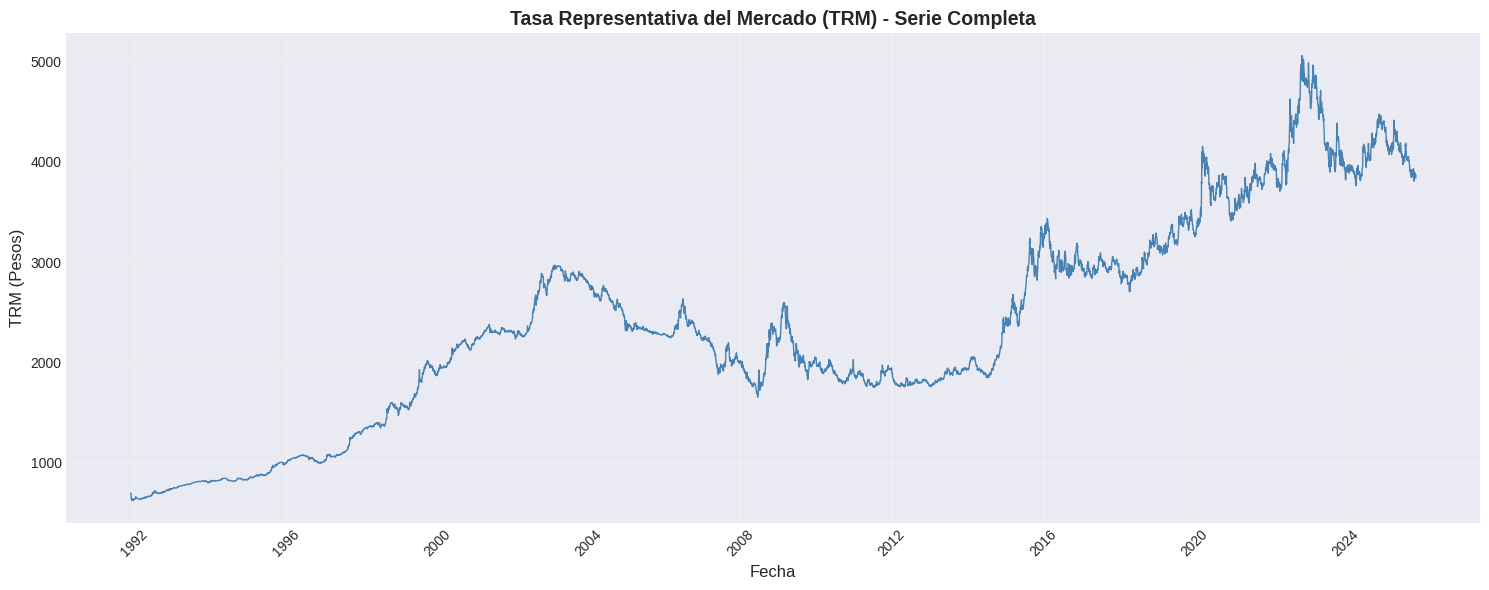

Gráfico generado: 8857 observaciones desde 1991-11-27 hasta 2025-11-06


In [24]:

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
print("\n4.1 Serie temporal de TRM")

fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(df['periodo'], df['trm'], linewidth=1, color='steelblue')
ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('TRM (Pesos)', fontsize=12)
ax.set_title('Tasa Representativa del Mercado (TRM) - Serie Completa', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
print(f"Gráfico generado: {len(df)} observaciones desde {df['periodo'].min().date()} hasta {df['periodo'].max().date()}")


4.2 Tendencia por años


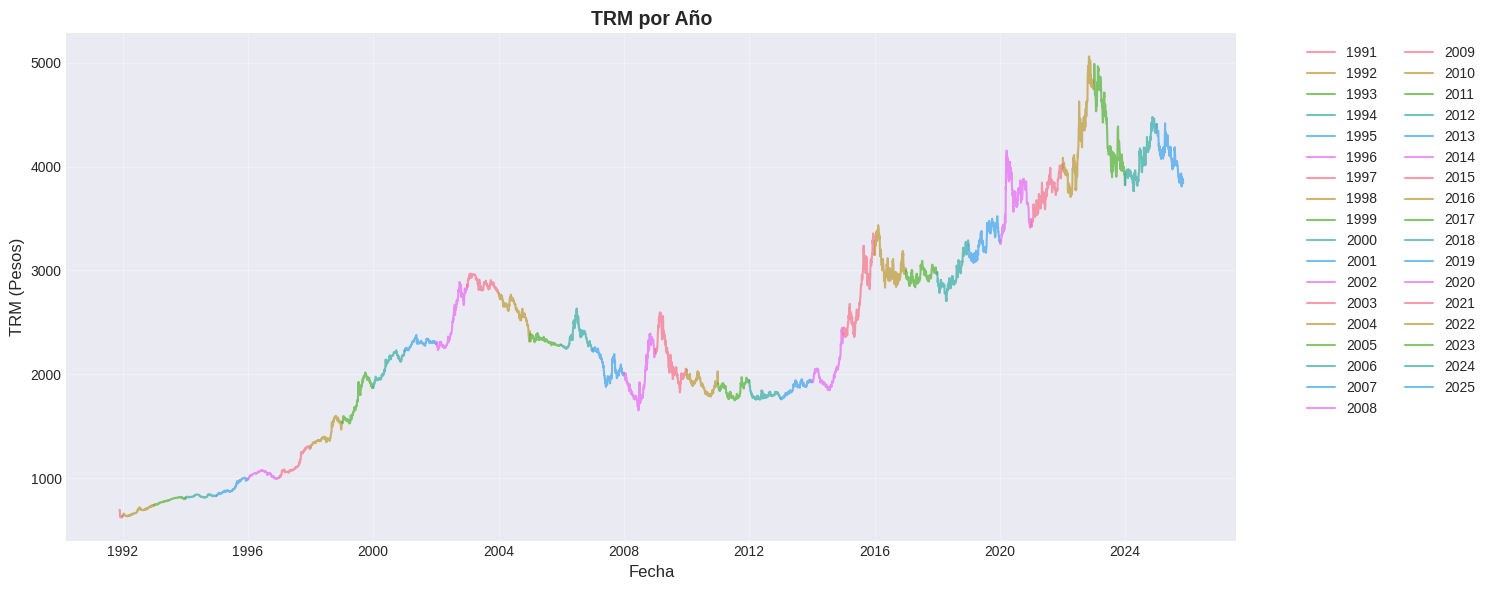


Estadísticas por año:
             mean      min      max         std  count
año                                                   
1991   637.498400   620.62   694.70   22.067336     25
1992   680.840420   632.37   738.19   33.143786    262
1993   786.628008   737.55   819.55   23.517599    261
1994   826.529692   804.33   844.40    9.752638    260
1995   912.769385   831.27  1003.47   56.093295    260
1996  1036.416489   987.65  1074.72   25.213294    262
1997  1141.090920  1005.33  1307.54   96.540769    261
1998  1426.528084  1293.58  1599.15   91.681364    261
1999  1757.263487  1525.59  2017.27  169.137027    261
2000  2088.117346  1873.77  2232.24  103.917884    260
2001  2299.662874  2219.60  2378.41   32.835003    261
2002  2505.745441  2231.98  2888.23  227.515942    261
2003  2876.609808  2778.21  2968.88   50.442156    261
2004  2627.713969  2316.12  2778.92   98.746685    262
2005  2321.096885  2272.95  2397.25   31.375946    260
2006  2359.683462  2225.44  2634.06   99.9

In [25]:
print("\n4.2 Tendencia por años")

df['año'] = df['periodo'].dt.year

fig, ax = plt.subplots(figsize=(15, 6))

# Gráfico por año
for año in sorted(df['año'].unique()):
    datos_año = df[df['año'] == año]
    ax.plot(datos_año['periodo'], datos_año['trm'], label=str(año), alpha=0.7)

ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('TRM (Pesos)', fontsize=12)
ax.set_title('TRM por Año', fontsize=14, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas por año
print("\nEstadísticas por año:")
stats_año = df.groupby('año')['trm'].agg(['mean', 'min', 'max', 'std', 'count'])
print(stats_año)


4.3 Distribución de valores de TRM


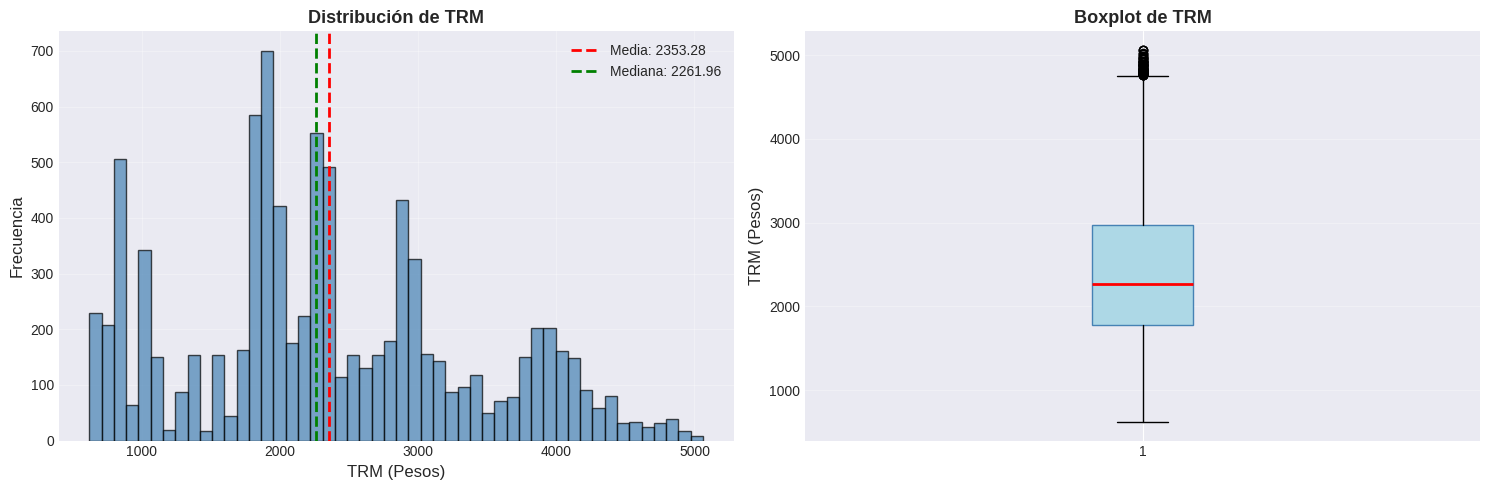

In [26]:
print("\n4.3 Distribución de valores de TRM")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
axes[0].hist(df['trm'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(df['trm'].mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {df["trm"].mean():.2f}')
axes[0].axvline(df['trm'].median(), color='green', linestyle='--', linewidth=2, label=f'Mediana: {df["trm"].median():.2f}')
axes[0].set_xlabel('TRM (Pesos)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de TRM', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# Boxplot
axes[1].boxplot(df['trm'], vert=True, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', color='steelblue'),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('TRM (Pesos)', fontsize=12)
axes[1].set_title('Boxplot de TRM', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


4.4 Primera diferencia (cambios diarios)


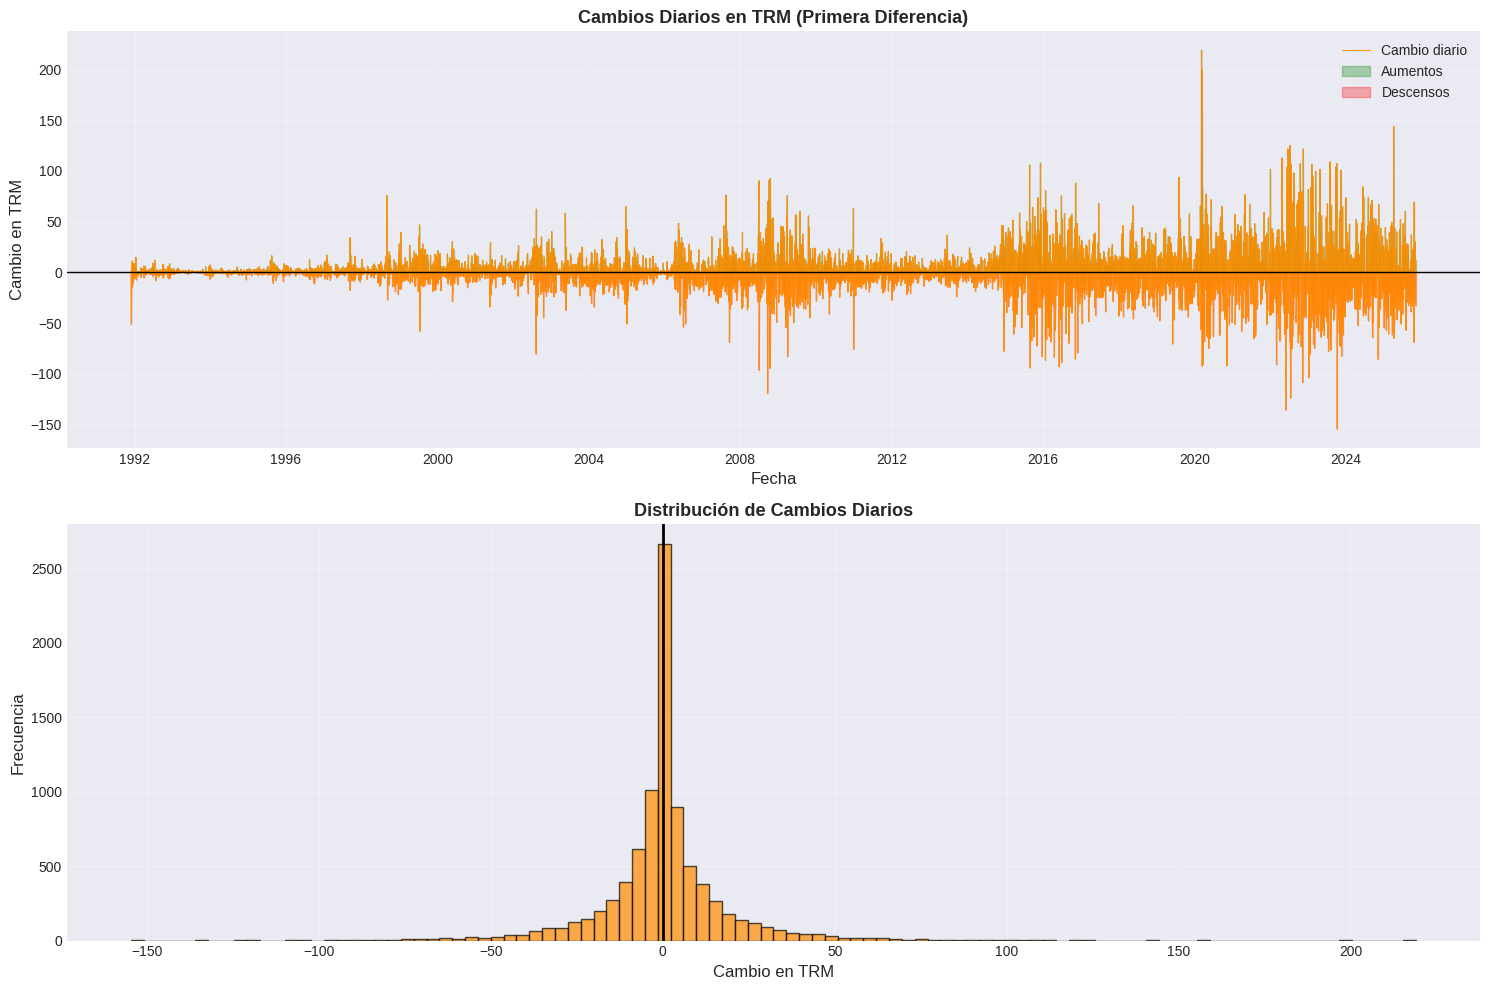


INTERPRETACIÓN (Primera diferencia):
  • Media ≈ 0.36 (cercana a 0) → cambios sin deriva sistemática.
  • Volatilidad diaria (σ): 19.14. El 90% central está entre -28.41 y 29.81.
  • Asimetría (skew): 0.59 → cola derecha.
  • Curtosis (exceso): 11.12 → colas pesadas.
  • Signo de los cambios: + 47.1% | - 44.5%
  • Años más volátiles (σ): 2022 (42.69), 2023 (41.35), 2020 (36.16)
  • Mayores aumentos: 2020-03-10: 219.02, 2020-03-13: 199.51, 2020-03-17: 158.01
  • Mayores caídas: 2023-10-11: -154.69, 2022-06-01: -135.82, 2022-07-18: -124.02


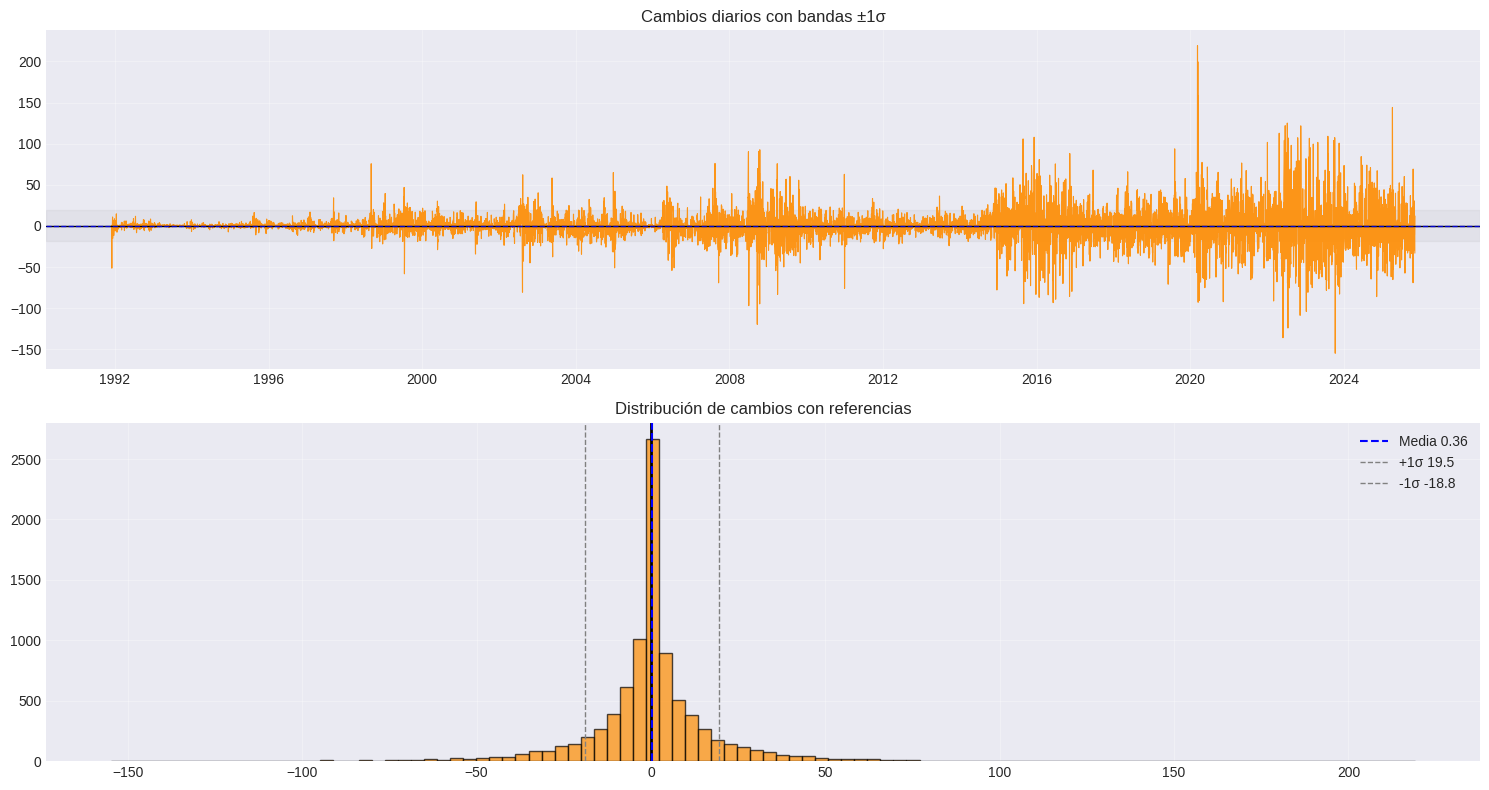


Cambios positivos: 4169 (47.1%)
Cambios negativos: 3940 (44.5%)


In [27]:
print("\n4.4 Primera diferencia (cambios diarios)")

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Serie temporal de cambios (añadir label para que aparezca en la leyenda)
linea_cambios = axes[0].plot(
    df['periodo'], df['primera_dif'],
    linewidth=0.8, color='darkorange', alpha=0.9,
    label='Cambio diario'
)

axes[0].axhline(y=0, color='black', linestyle='-', linewidth=1)

# Fill positivos y negativos (con labels)
aumentos = axes[0].fill_between(
    df['periodo'], df['primera_dif'], 0,
    where=(df['primera_dif'] > 0),
    color='green', alpha=0.3, label='Aumentos'
)
descensos = axes[0].fill_between(
    df['periodo'], df['primera_dif'], 0,
    where=(df['primera_dif'] <= 0),
    color='red', alpha=0.3, label='Descensos'
)

axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('Cambio en TRM', fontsize=12)
axes[0].set_title('Cambios Diarios en TRM (Primera Diferencia)', fontsize=13, fontweight='bold')
# Forzar orden en la leyenda
handles = [linea_cambios[0], aumentos, descensos]
labels = [h.get_label() for h in handles]
axes[0].legend(handles, labels)
axes[0].grid(True, alpha=0.3)

# Histograma de cambios
axes[1].hist(df['primera_dif'].dropna(), bins=100, color='darkorange', alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='black', linestyle='-', linewidth=2)
axes[1].set_xlabel('Cambio en TRM', fontsize=12)
axes[1].set_ylabel('Frecuencia', fontsize=12)
axes[1].set_title('Distribución de Cambios Diarios', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Interpretación automática de la primera diferencia ---
dif = df[['periodo', 'primera_dif']].dropna().copy()
mu = dif['primera_dif'].mean()
sigma = dif['primera_dif'].std()
q05, q50, q95 = dif['primera_dif'].quantile([0.05, 0.5, 0.95])
skew = dif['primera_dif'].skew()
kurt = dif['primera_dif'].kurt()  # exceso de curtosis (Fisher)
pos_pct = (dif['primera_dif'] > 0).mean() * 100
neg_pct = (dif['primera_dif'] < 0).mean() * 100

# Años más volátiles
dif['año'] = dif['periodo'].dt.year
vol_por_año = dif.groupby('año')['primera_dif'].std().sort_values(ascending=False).head(3)

# Outliers (máximos aumentos/caídas)
out_pos = dif.nlargest(3, 'primera_dif')
out_neg = dif.nsmallest(3, 'primera_dif')

print("\nINTERPRETACIÓN (Primera diferencia):")
print(f"  • Media ≈ {mu:.2f} (cercana a 0) → cambios sin deriva sistemática.")
print(f"  • Volatilidad diaria (σ): {sigma:.2f}. El 90% central está entre {q05:.2f} y {q95:.2f}.")
print(f"  • Asimetría (skew): {skew:.2f} {'→ cola derecha' if skew>0 else '→ cola izquierda' if skew<0 else ''}.")
print(f"  • Curtosis (exceso): {kurt:.2f} {'→ colas pesadas' if kurt>0 else '→ colas ligeras/meseta'}.")
print(f"  • Signo de los cambios: + {pos_pct:.1f}% | - {neg_pct:.1f}%")
print("  • Años más volátiles (σ): " + ", ".join([f"{int(a)} ({v:.2f})" for a, v in vol_por_año.items()]))
print("  • Mayores aumentos: " + ", ".join([f"{r['periodo'].date()}: {r['primera_dif']:.2f}" for _, r in out_pos.iterrows()]))
print("  • Mayores caídas: " + ", ".join([f"{r['periodo'].date()}: {r['primera_dif']:.2f}" for _, r in out_neg.iterrows()]))

# Opcional: reanotar el gráfico con bandas ±1σ y líneas en el histograma
fig, axes = plt.subplots(2, 1, figsize=(15, 8))
axes[0].plot(dif['periodo'], dif['primera_dif'], color='darkorange', linewidth=0.8, alpha=0.9, label='Cambio diario')
axes[0].axhline(0, color='black', linewidth=1)
axes[0].axhline(mu, color='blue', linestyle='--', linewidth=1, alpha=0.8)
axes[0].axhspan(mu - sigma, mu + sigma, color='grey', alpha=0.08)
axes[0].set_title('Cambios diarios con bandas ±1σ')
axes[0].grid(True, alpha=0.3)

axes[1].hist(dif['primera_dif'], bins=100, color='darkorange', alpha=0.7, edgecolor='black')
axes[1].axvline(0, color='black', linewidth=2)
axes[1].axvline(mu, color='blue', linestyle='--', linewidth=1.5, label=f"Media {mu:.2f}")
axes[1].axvline(mu + sigma, color='grey', linestyle='--', linewidth=1, label=f"+1σ {mu+sigma:.1f}")
axes[1].axvline(mu - sigma, color='grey', linestyle='--', linewidth=1, label=f"-1σ {mu-sigma:.1f}")
axes[1].set_title('Distribución de cambios con referencias')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCambios positivos: {(df['primera_dif'] > 0).sum()} ({(df['primera_dif'] > 0).sum()/len(df)*100:.1f}%)")
print(f"Cambios negativos: {(df['primera_dif'] < 0).sum()} ({(df['primera_dif'] < 0).sum()/len(df)*100:.1f}%)")



4.5 Comportamiento por día de la semana


/tmp/ipykernel_236443/2113891279.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cambios_dia = df_dias.groupby('dia_cat')['primera_dif'].mean()
/tmp/ipykernel_236443/2113891279.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vol_dia = df_dias.groupby('dia_cat')['primera_dif'].std()


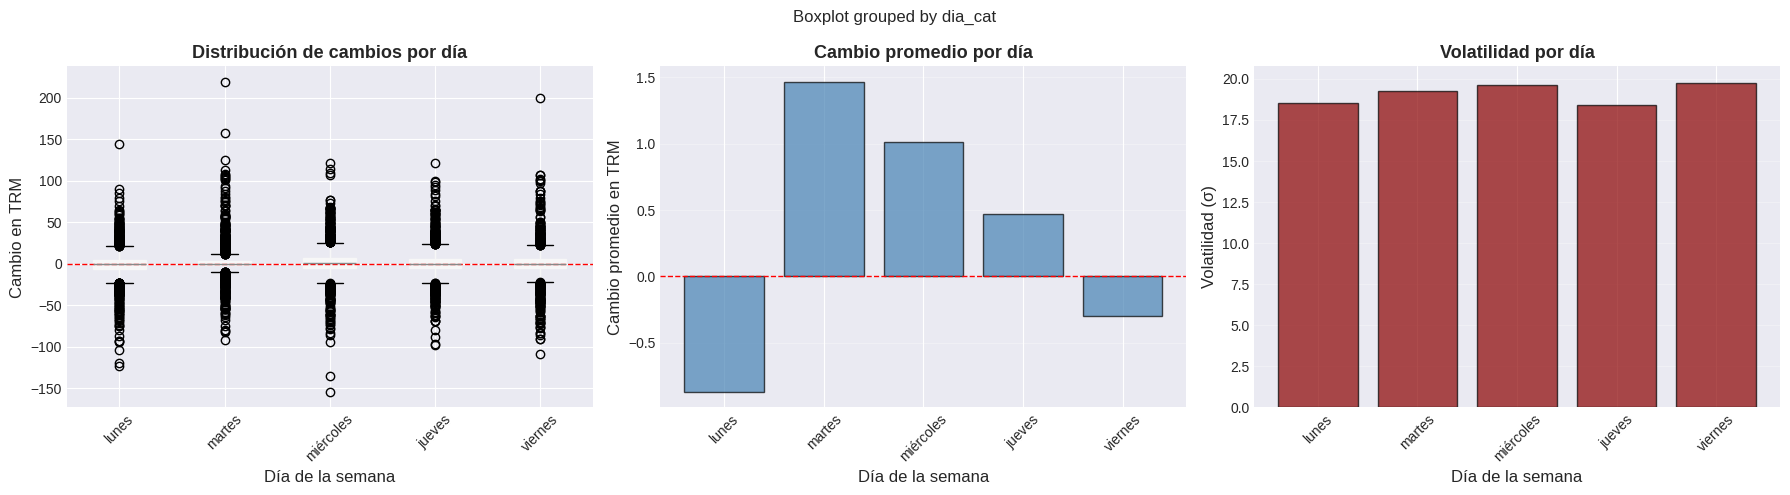


ANÁLISIS POR DÍA DE LA SEMANA:
  • Día con mayor cambio promedio: martes (1.47)
  • Día con menor cambio promedio: lunes (-0.87)
  • Día más volátil: viernes (σ=19.77)
  • Día menos volátil: jueves (σ=18.44)


In [28]:
print("\n4.5 Comportamiento por día de la semana")

orden_dias = ['lunes', 'martes', 'miércoles', 'jueves', 'viernes']
df['dia_cat'] = pd.Categorical(df['dia'], categories=orden_dias, ordered=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df_dias = df[df['dia'].isin(orden_dias)].copy()
df_dias['dia_cat'] = pd.Categorical(df_dias['dia'], categories=orden_dias, ordered=True)

# 1. Boxplot de CAMBIOS (primera_dif)
df_dias.boxplot(column='primera_dif', by='dia_cat', ax=axes[0], patch_artist=True)
axes[0].set_xlabel('Día de la semana', fontsize=12)
axes[0].set_ylabel('Cambio en TRM', fontsize=12)
axes[0].set_title('Distribución de cambios por día', fontsize=13, fontweight='bold')
axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
plt.sca(axes[0])
plt.xticks(rotation=45)

# 2. Cambios promedio por día
cambios_dia = df_dias.groupby('dia_cat')['primera_dif'].mean()
axes[1].bar(range(len(cambios_dia)), cambios_dia.values, color='steelblue', alpha=0.7, edgecolor='black')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1].set_xticks(range(len(cambios_dia)))
axes[1].set_xticklabels(cambios_dia.index, rotation=45)
axes[1].set_xlabel('Día de la semana', fontsize=12)
axes[1].set_ylabel('Cambio promedio en TRM', fontsize=12)
axes[1].set_title('Cambio promedio por día', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# 3. Volatilidad por día
vol_dia = df_dias.groupby('dia_cat')['primera_dif'].std()
axes[2].bar(range(len(vol_dia)), vol_dia.values, color='darkred', alpha=0.7, edgecolor='black')
axes[2].set_xticks(range(len(vol_dia)))
axes[2].set_xticklabels(vol_dia.index, rotation=45)
axes[2].set_xlabel('Día de la semana', fontsize=12)
axes[2].set_ylabel('Volatilidad (σ)', fontsize=12)
axes[2].set_title('Volatilidad por día', fontsize=13, fontweight='bold')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Interpretación
print("\nANÁLISIS POR DÍA DE LA SEMANA:")
print(f"  • Día con mayor cambio promedio: {cambios_dia.idxmax()} ({cambios_dia.max():.2f})")
print(f"  • Día con menor cambio promedio: {cambios_dia.idxmin()} ({cambios_dia.min():.2f})")
print(f"  • Día más volátil: {vol_dia.idxmax()} (σ={vol_dia.max():.2f})")
print(f"  • Día menos volátil: {vol_dia.idxmin()} (σ={vol_dia.min():.2f})")


4.6 Análisis de Tendencia y Volatilidad Móvil


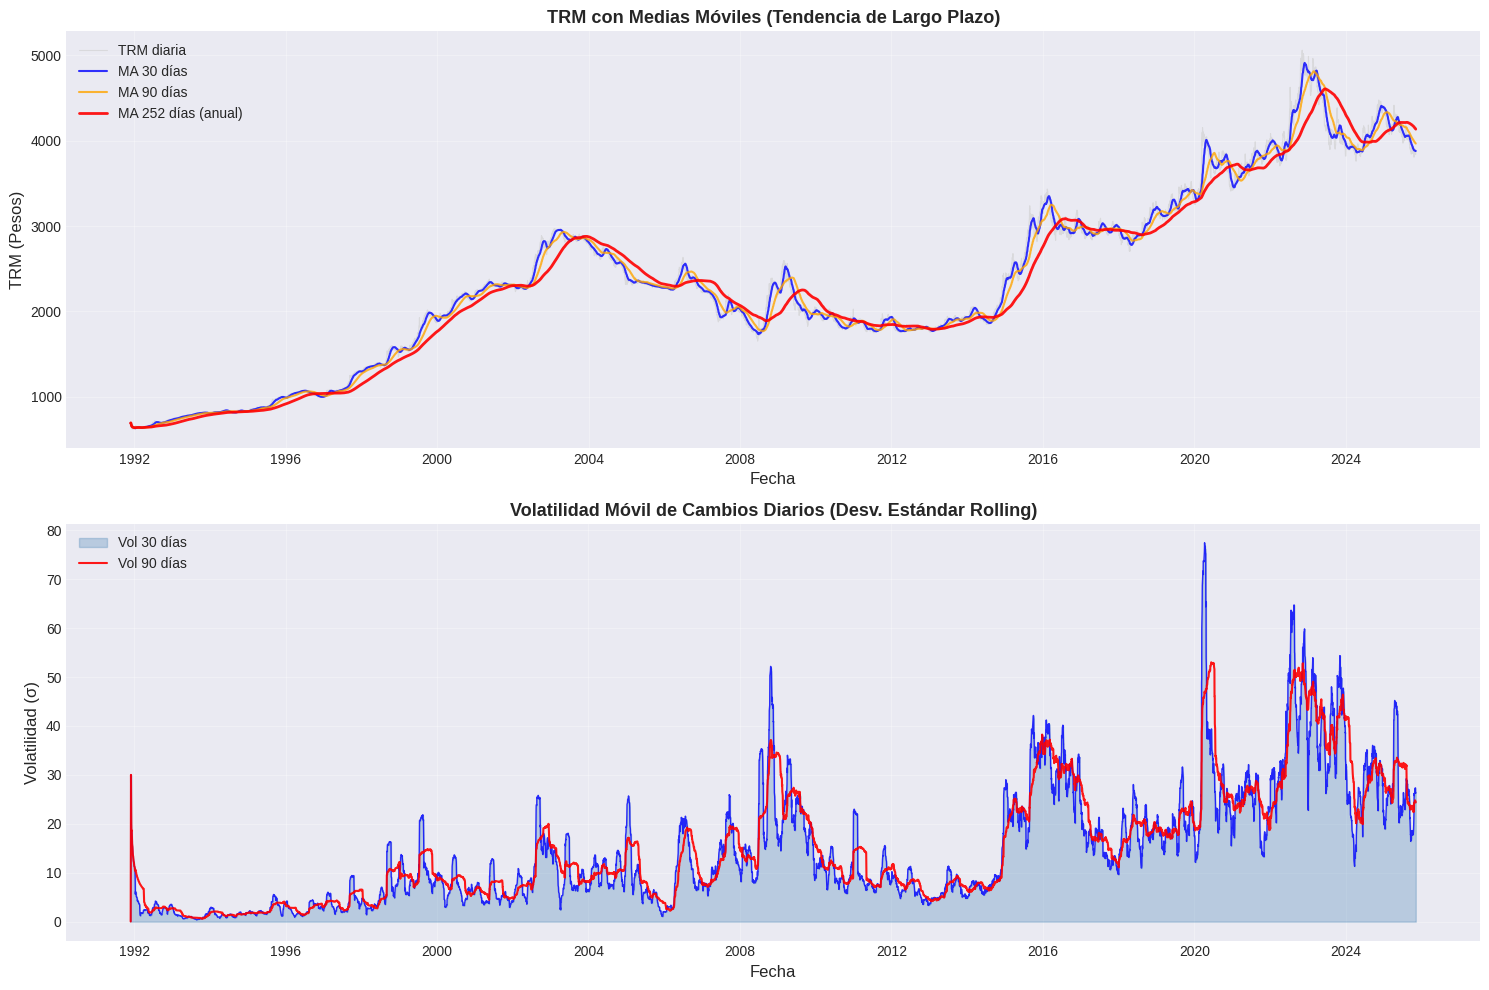


INTERPRETACIÓN (Tendencia y Volatilidad):
  • Tendencia de largo plazo (MA 252d): 669.77 → 4136.56 (+517.6%)
  • Volatilidad actual (30d): 26.25 | Promedio histórico: 14.51
  • Pico de volatilidad: 77.46 en 2020-04-09
  • Años con más días de alta volatilidad (>p90): 2023 (219d), 2022 (174d), 2016 (115d)
  → RÉGIMEN ACTUAL: Volatilidad moderada


In [29]:
print("\n4.6 Análisis de Tendencia y Volatilidad Móvil")

# Calcular medias móviles y volatilidad
df['ma_30'] = df['trm'].rolling(window=30, min_periods=1).mean()
df['ma_90'] = df['trm'].rolling(window=90, min_periods=1).mean()
df['ma_252'] = df['trm'].rolling(window=252, min_periods=1).mean()

# Volatilidad móvil (desviación estándar de primera_dif)
df['vol_30'] = df['primera_dif'].rolling(window=30, min_periods=1).std()
df['vol_90'] = df['primera_dif'].rolling(window=90, min_periods=1).std()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# --- Panel 1: TRM con Medias Móviles ---
axes[0].plot(df['periodo'], df['trm'], linewidth=0.8, color='lightgrey', alpha=0.7, label='TRM diaria')
axes[0].plot(df['periodo'], df['ma_30'], linewidth=1.5, color='blue', alpha=0.8, label='MA 30 días')
axes[0].plot(df['periodo'], df['ma_90'], linewidth=1.5, color='orange', alpha=0.8, label='MA 90 días')
axes[0].plot(df['periodo'], df['ma_252'], linewidth=2, color='red', alpha=0.9, label='MA 252 días (anual)')
axes[0].set_xlabel('Fecha', fontsize=12)
axes[0].set_ylabel('TRM (Pesos)', fontsize=12)
axes[0].set_title('TRM con Medias Móviles (Tendencia de Largo Plazo)', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# --- Panel 2: Volatilidad Móvil ---
axes[1].fill_between(df['periodo'], 0, df['vol_30'], color='steelblue', alpha=0.3, label='Vol 30 días')
axes[1].plot(df['periodo'], df['vol_30'], linewidth=1, color='blue', alpha=0.8)
axes[1].plot(df['periodo'], df['vol_90'], linewidth=1.5, color='red', alpha=0.9, label='Vol 90 días')
axes[1].set_xlabel('Fecha', fontsize=12)
axes[1].set_ylabel('Volatilidad (σ)', fontsize=12)
axes[1].set_title('Volatilidad Móvil de Cambios Diarios (Desv. Estándar Rolling)', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Interpretación automática ---
vol_actual = df['vol_30'].iloc[-1]
vol_promedio = df['vol_30'].mean()
vol_max = df['vol_30'].max()
vol_max_fecha = df.loc[df['vol_30'].idxmax(), 'periodo']

# Identificar periodos de alta volatilidad (>percentil 90)
umbral_vol = df['vol_30'].quantile(0.90)
periodos_alta_vol = df[df['vol_30'] > umbral_vol][['periodo', 'vol_30']].copy()
periodos_alta_vol['año'] = periodos_alta_vol['periodo'].dt.year
top_años_vol = periodos_alta_vol.groupby('año').size().sort_values(ascending=False).head(3)

# Tendencia de la media móvil anual
ma_252_inicio = df['ma_252'].iloc[252] if len(df) > 252 else df['ma_252'].iloc[0]
ma_252_actual = df['ma_252'].iloc[-1]
cambio_tendencia = ((ma_252_actual - ma_252_inicio) / ma_252_inicio) * 100

print("\nINTERPRETACIÓN (Tendencia y Volatilidad):")
print(f"  • Tendencia de largo plazo (MA 252d): {ma_252_inicio:.2f} → {ma_252_actual:.2f} ({cambio_tendencia:+.1f}%)")
print(f"  • Volatilidad actual (30d): {vol_actual:.2f} | Promedio histórico: {vol_promedio:.2f}")
print(f"  • Pico de volatilidad: {vol_max:.2f} en {vol_max_fecha.date()}")
print(f"  • Años con más días de alta volatilidad (>p90): {', '.join([f'{int(a)} ({c}d)' for a, c in top_años_vol.items()])}")

# Régimen actual
if vol_actual > umbral_vol:
    print(f"  RÉGIMEN ACTUAL: Alta volatilidad (>{umbral_vol:.2f})")
elif vol_actual < df['vol_30'].quantile(0.25):
    print(f"  ✓ RÉGIMEN ACTUAL: Baja volatilidad (<{df['vol_30'].quantile(0.25):.2f})")
else:
    print(f"  → RÉGIMEN ACTUAL: Volatilidad moderada")

In [30]:
print("=" * 60)
print("TESTS ESTADÍSTICOS")
print("=" * 60)
#Test de Dickey-Fuller Aumentado (ADF) - Prueba de Estacionariedad
print("\nTEST DE ESTACIONARIEDAD (Augmented Dickey-Fuller)")
print("-" * 60)

def test_adf(serie, nombre):
    """Realiza el test ADF y muestra resultados interpretados"""
    serie_limpia = serie.dropna()
    resultado = adfuller(serie_limpia, autolag='AIC')
    
    print(f"\n{nombre}:")
    print(f"  Estadístico ADF: {resultado[0]:.6f}")
    print(f"  p-value: {resultado[1]:.6f}")
    print(f"  Valores críticos:")
    for key, value in resultado[4].items():
        print(f"    {key}: {value:.3f}")
    
    # Interpretación
    if resultado[1] < 0.05:
        print(f"   Serie ESTACIONARIA (p-value < 0.05)")
    else:
        print(f"   Serie NO ESTACIONARIA (p-value >= 0.05)")
    
    return resultado[1] < 0.05

# Test en TRM original
es_estacionaria_trm = test_adf(df['trm'], "TRM Original")


TESTS ESTADÍSTICOS

TEST DE ESTACIONARIEDAD (Augmented Dickey-Fuller)
------------------------------------------------------------

TRM Original:
  Estadístico ADF: -1.137085
  p-value: 0.700059
  Valores críticos:
    1%: -3.431
    5%: -2.862
    10%: -2.567
   Serie NO ESTACIONARIA (p-value >= 0.05)


In [31]:

# Test en primera diferencia
es_estacionaria_dif1 = test_adf(df['primera_dif'], "Primera Diferencia")

# Test en segunda diferencia
es_estacionaria_dif2 = test_adf(df['segunda_dif'], "Segunda Diferencia")


Primera Diferencia:
  Estadístico ADF: -15.806299
  p-value: 0.000000
  Valores críticos:
    1%: -3.431
    5%: -2.862
    10%: -2.567
   Serie ESTACIONARIA (p-value < 0.05)

Segunda Diferencia:
  Estadístico ADF: -15.036117
  p-value: 0.000000
  Valores críticos:
    1%: -3.431
    5%: -2.862
    10%: -2.567
   Serie ESTACIONARIA (p-value < 0.05)



FUNCIONES DE AUTOCORRELACIÓN
------------------------------------------------------------


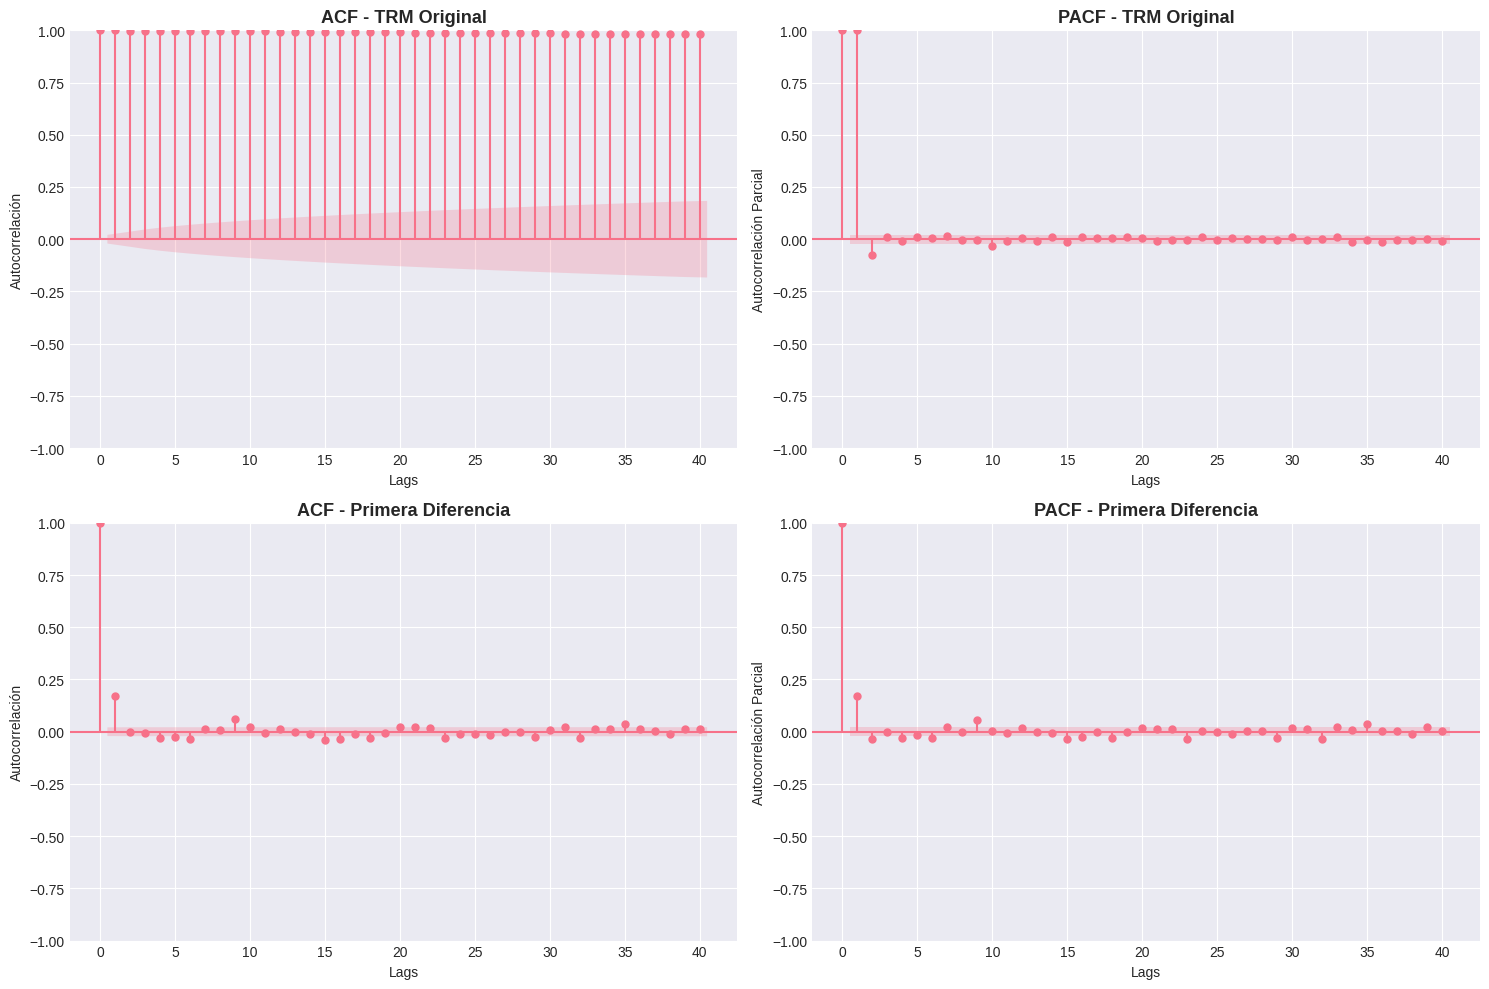


✓ Gráficos generados

Interpretación:
  - ACF: mide correlación entre observaciones a diferentes lags
  - PACF: correlación parcial removiendo efectos de lags intermedios
  - Barras fuera del área sombreada = correlaciones significativas


In [32]:
#Análisis de Autocorrelación (ACF y PACF)
print("\n" + "=" * 60)
print("FUNCIONES DE AUTOCORRELACIÓN")
print("-" * 60)

# Preparar datos sin nulos
trm_limpia = df['trm'].dropna()
primera_dif_limpia = df['primera_dif'].dropna()

# Gráficos de ACF y PACF
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ACF para TRM original
plot_acf(trm_limpia, lags=40, ax=axes[0, 0], alpha=0.05)
axes[0, 0].set_title('ACF - TRM Original', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Lags')
axes[0, 0].set_ylabel('Autocorrelación')

# PACF para TRM original
plot_pacf(trm_limpia, lags=40, ax=axes[0, 1], alpha=0.05)
axes[0, 1].set_title('PACF - TRM Original', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Lags')
axes[0, 1].set_ylabel('Autocorrelación Parcial')

# ACF para Primera Diferencia
plot_acf(primera_dif_limpia, lags=40, ax=axes[1, 0], alpha=0.05)
axes[1, 0].set_title('ACF - Primera Diferencia', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Lags')
axes[1, 0].set_ylabel('Autocorrelación')

# PACF para Primera Diferencia
plot_pacf(primera_dif_limpia, lags=40, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('PACF - Primera Diferencia', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Lags')
axes[1, 1].set_ylabel('Autocorrelación Parcial')

plt.tight_layout()
plt.show()

print("\n✓ Gráficos generados")
print("\nInterpretación:")
print("  - ACF: mide correlación entre observaciones a diferentes lags")
print("  - PACF: correlación parcial removiendo efectos de lags intermedios")
print("  - Barras fuera del área sombreada = correlaciones significativas")


5.3 MATRIZ DE CORRELACIÓN
------------------------------------------------------------


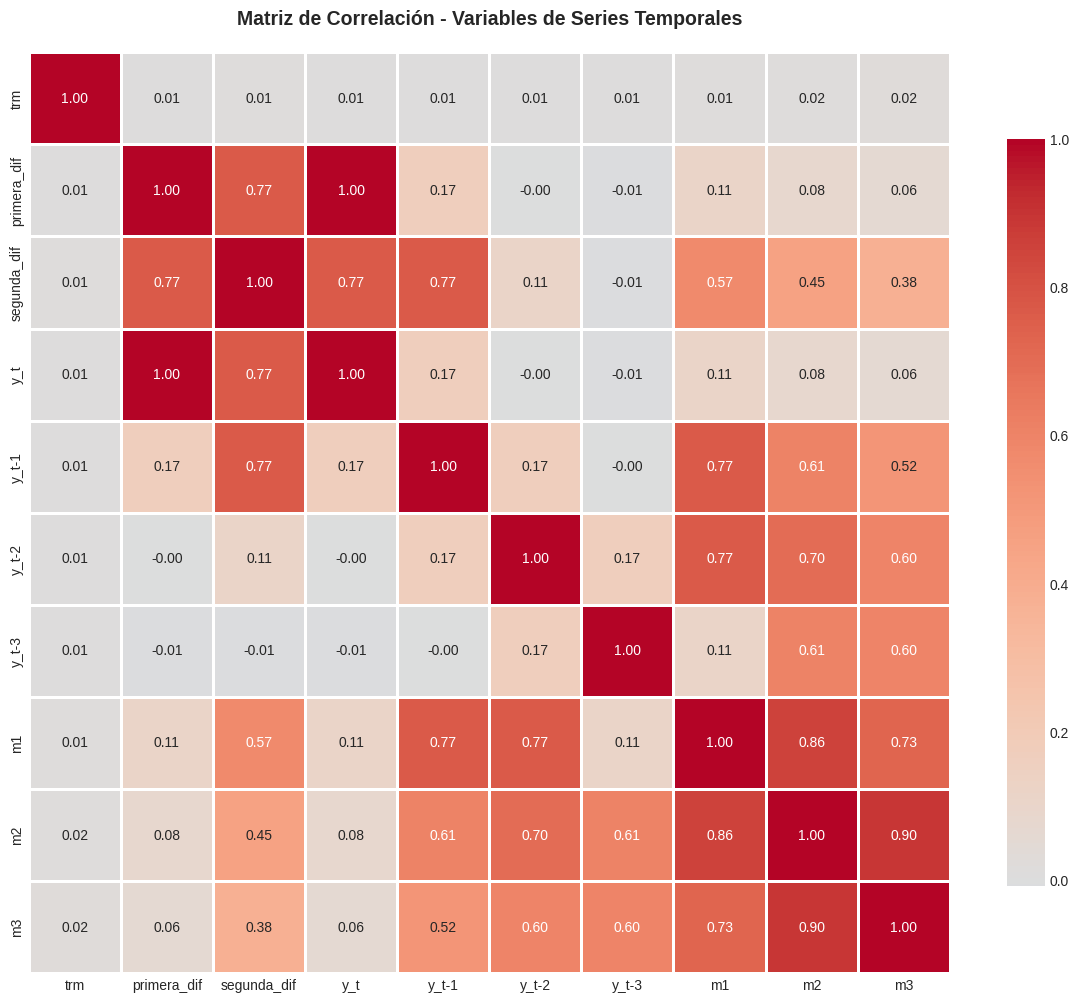


Correlaciones más fuertes con TRM:
trm            1.000000
m3             0.019268
m2             0.017020
m1             0.014213
segunda_dif    0.011690
y_t-2          0.011054
y_t-3          0.010894
y_t-1          0.010699
primera_dif    0.007191
y_t            0.007191
Name: trm, dtype: float64


In [33]:
#Análisis de correlaciones entre variables
print("\n" + "=" * 60)
print("5.3 MATRIZ DE CORRELACIÓN")
print("-" * 60)

# Seleccionar variables numéricas relevantes
columnas_analisis = ['trm', 'primera_dif', 'segunda_dif', 'y_t', 'y_t-1', 'y_t-2', 'y_t-3', 'm1', 'm2', 'm3']
df_corr = df[columnas_analisis].dropna()

# Calcular matriz de correlación
matriz_correlacion = df_corr.corr()

# Visualizar matriz de correlación
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(matriz_correlacion, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Matriz de Correlación - Variables de Series Temporales', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Mostrar correlaciones más fuertes con TRM
print("\nCorrelaciones más fuertes con TRM:")
corr_con_trm = matriz_correlacion['trm'].sort_values(ascending=False)
print(corr_con_trm)


 DESCOMPOSICIÓN DE LA SERIE TEMPORAL
------------------------------------------------------------


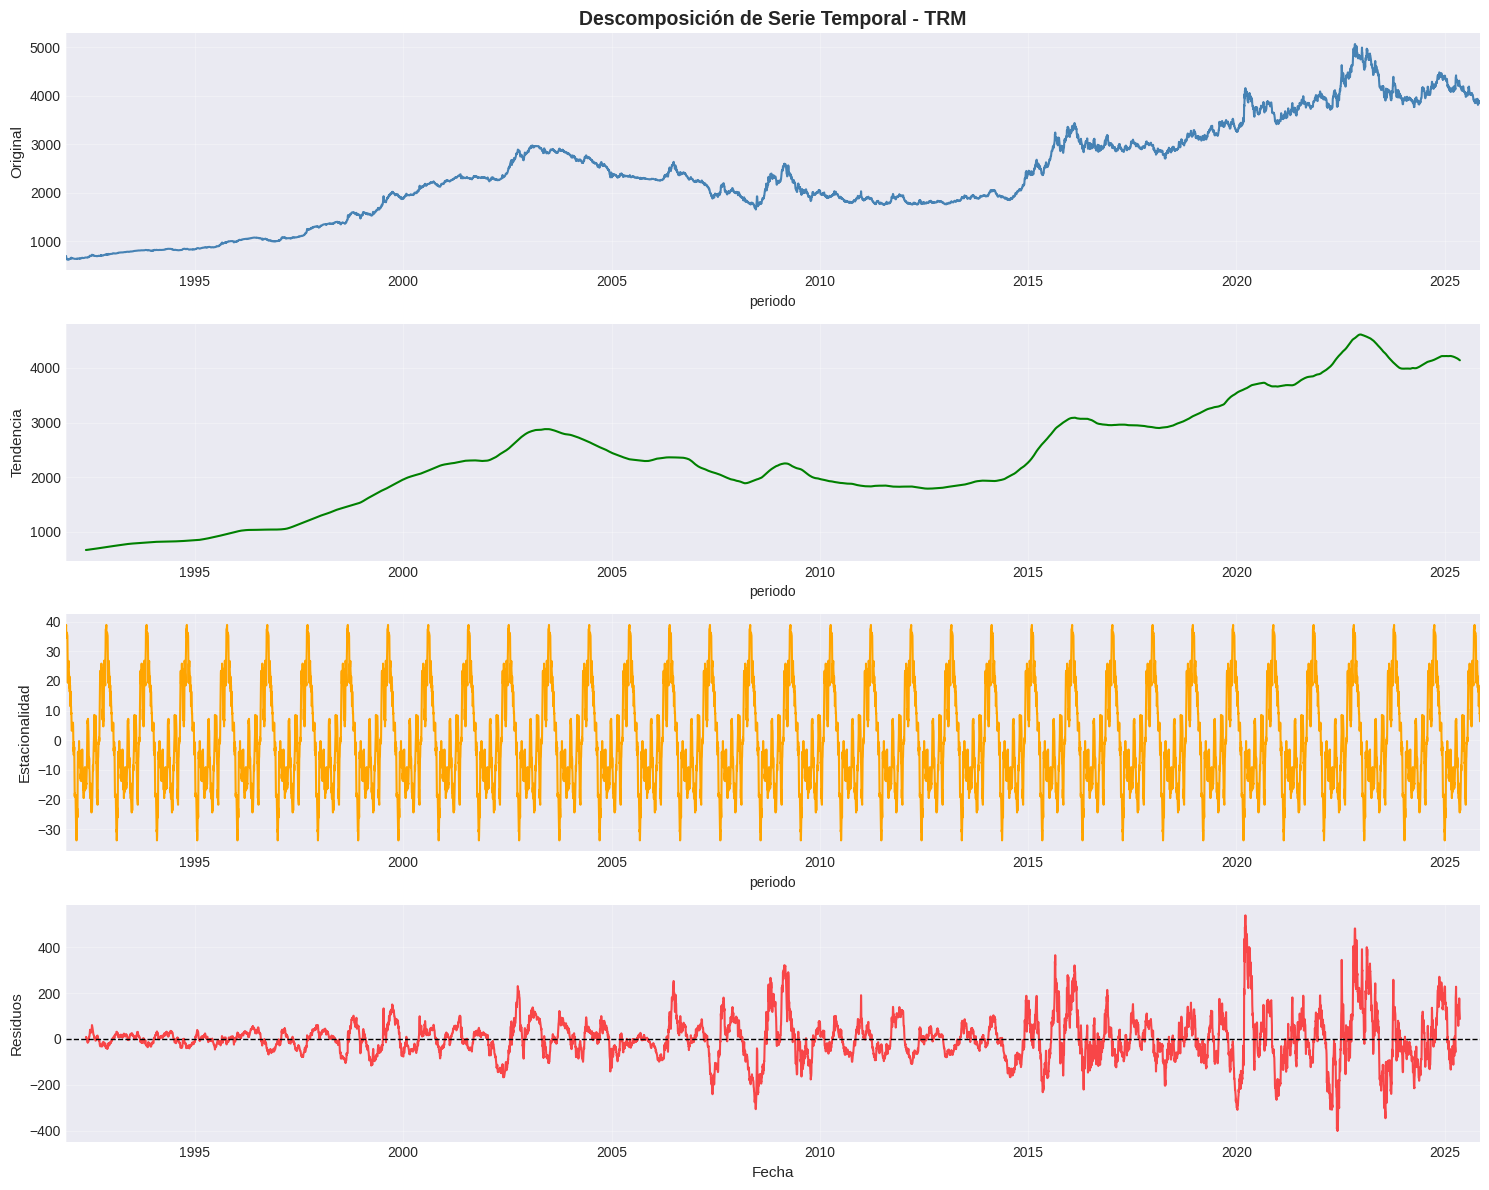


✓ Descomposición completada

Componentes:
  - Tendencia: patrón de largo plazo
  - Estacionalidad: patrones que se repiten periódicamente
  - Residuos: variaciones aleatorias (ruido)

ANÁLISIS DE COMPONENTES:
  • Rango de tendencia: 669.71 - 4608.61
  • Amplitud estacional: 72.72
  • Volatilidad residuos (σ): 92.73
  • % varianza explicada por tendencia: 99.2%


In [34]:
#  Análisis de componentes temporales (descomposición)
print("\n" + "=" * 60)
print(" DESCOMPOSICIÓN DE LA SERIE TEMPORAL")
print("-" * 60)

# Usar dataframe con índice temporal
df_temporal_limpio = df_temporal['trm'].dropna()

# Descomposición (additive model)
# Usar period=252 (aprox días hábiles en un año)
decomposicion = seasonal_decompose(df_temporal_limpio, model='additive', period=252)

# Visualizar componentes
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Serie original
df_temporal_limpio.plot(ax=axes[0], color='steelblue')
axes[0].set_ylabel('Original', fontsize=11)
axes[0].set_title('Descomposición de Serie Temporal - TRM', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Tendencia
decomposicion.trend.plot(ax=axes[1], color='green')
axes[1].set_ylabel('Tendencia', fontsize=11)
axes[1].grid(True, alpha=0.3)

# Estacionalidad
decomposicion.seasonal.plot(ax=axes[2], color='orange')
axes[2].set_ylabel('Estacionalidad', fontsize=11)
axes[2].grid(True, alpha=0.3)

# Residuos
decomposicion.resid.plot(ax=axes[3], color='red', alpha=0.7)
axes[3].axhline(0, color='black', linestyle='--', linewidth=1)
axes[3].set_ylabel('Residuos', fontsize=11)
axes[3].set_xlabel('Fecha', fontsize=11)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Interpretación cuantitativa
print("\n✓ Descomposición completada")
print("\nComponentes:")
print("  - Tendencia: patrón de largo plazo")
print("  - Estacionalidad: patrones que se repiten periódicamente")
print("  - Residuos: variaciones aleatorias (ruido)")

# Análisis adicional
trend_clean = decomposicion.trend.dropna()
seasonal_clean = decomposicion.seasonal.dropna()
resid_clean = decomposicion.resid.dropna()

print(f"\nANÁLISIS DE COMPONENTES:")
print(f"  • Rango de tendencia: {trend_clean.min():.2f} - {trend_clean.max():.2f}")
print(f"  • Amplitud estacional: {seasonal_clean.max() - seasonal_clean.min():.2f}")
print(f"  • Volatilidad residuos (σ): {resid_clean.std():.2f}")
print(f"  • % varianza explicada por tendencia: {(1 - resid_clean.var()/df_temporal_limpio.var())*100:.1f}%")

In [35]:
#Resumen de hallazgos estadísticos
print("\n" + "=" * 60)
print("RESUMEN DE ANÁLISIS ESTADÍSTICO")
print("=" * 60)

print(f"""
ESTACIONARIEDAD:
  • TRM Original: {'Estacionaria' if es_estacionaria_trm else 'NO Estacionaria'}
  • Primera Diferencia: {'Estacionaria' if es_estacionaria_dif1 else 'NO Estacionaria'}
  • Segunda Diferencia: {'Estacionaria' if es_estacionaria_dif2 else 'NO Estacionaria'}

IMPLICACIONES PARA REDES NEURONALES:
  ✓ Si la serie NO es estacionaria: usar diferenciación o normalización
  ✓ ACF/PACF ayudan a determinar lags óptimos para el modelo
  ✓ Variables autoregresivas (y_t-1, y_t-2, etc.) capturan dependencia temporal
  
PRÓXIMOS PASOS:
  1. Manejo de valores nulos
  2. Normalización/Escalado de datos
  3. Creación de secuencias para LSTM/GRU
  4. División en train/validation/test
""")


RESUMEN DE ANÁLISIS ESTADÍSTICO

ESTACIONARIEDAD:
  • TRM Original: NO Estacionaria
  • Primera Diferencia: Estacionaria
  • Segunda Diferencia: Estacionaria

IMPLICACIONES PARA REDES NEURONALES:
  ✓ Si la serie NO es estacionaria: usar diferenciación o normalización
  ✓ ACF/PACF ayudan a determinar lags óptimos para el modelo
  ✓ Variables autoregresivas (y_t-1, y_t-2, etc.) capturan dependencia temporal
  
PRÓXIMOS PASOS:
  1. Manejo de valores nulos
  2. Normalización/Escalado de datos
  3. Creación de secuencias para LSTM/GRU
  4. División en train/validation/test




4.7 Comportamiento de la Estacionariedad de la Primera Diferencia


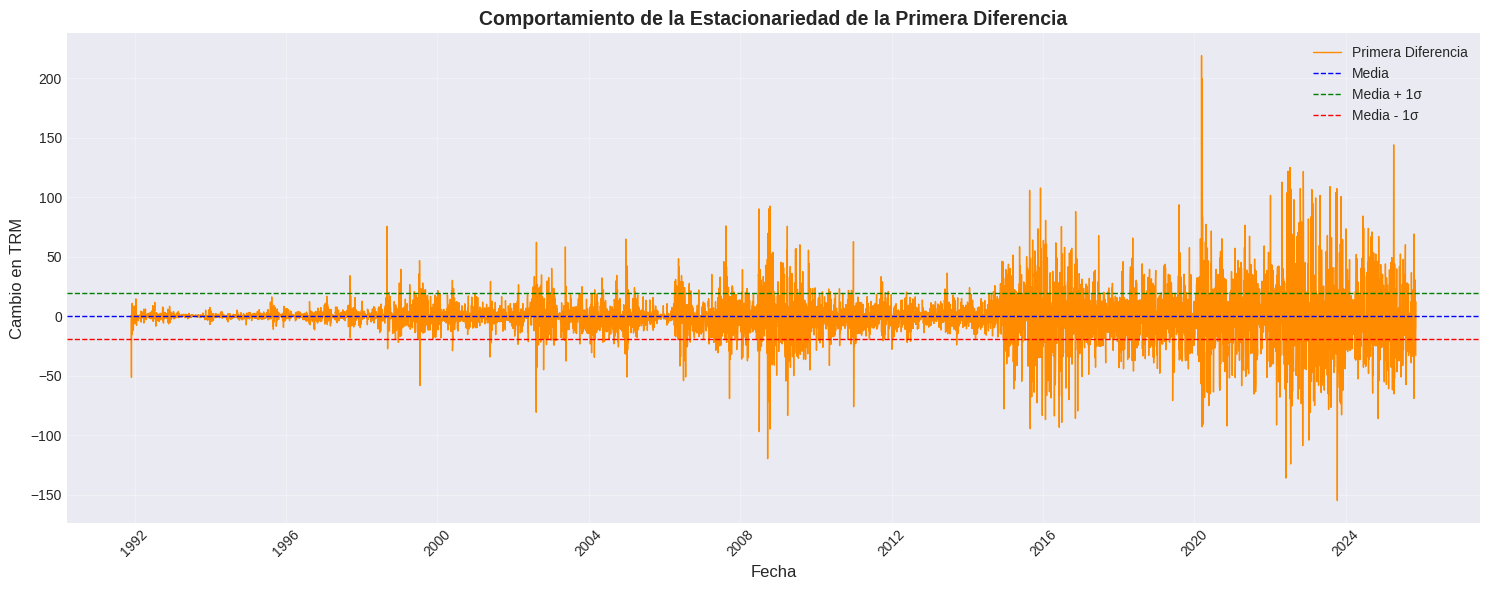

In [37]:
print("\n4.7 Comportamiento de la Estacionariedad de la Primera Diferencia")

# Calcular media y desviación estándar de la primera diferencia
media_dif = df['primera_dif'].mean()
std_dif = df['primera_dif'].std()

fig, ax = plt.subplots(figsize=(15, 6))

# Graficar la primera diferencia
ax.plot(df['periodo'], df['primera_dif'], color='darkorange', linewidth=1, label='Primera Diferencia')

# Añadir líneas de media y desviación estándar
ax.axhline(media_dif, color='blue', linestyle='--', linewidth=1, label='Media')
ax.axhline(media_dif + std_dif, color='green', linestyle='--', linewidth=1, label='Media + 1σ')
ax.axhline(media_dif - std_dif, color='red', linestyle='--', linewidth=1, label='Media - 1σ')

ax.set_xlabel('Fecha', fontsize=12)
ax.set_ylabel('Cambio en TRM', fontsize=12)
ax.set_title('Comportamiento de la Estacionariedad de la Primera Diferencia', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:

# Revisar valores nulos
print("\nValores nulos por columna:")
nulos = df.isnull().sum()
print(nulos[nulos > 0])

# Estrategia: eliminar filas con nulos en variables clave
# Las diferencias tienen nulos naturales al inicio de la serie
columnas_criticas = ['trm', 'periodo']
df_clean = df.dropna(subset=columnas_criticas)

print(f"\nFilas antes de limpiar: {len(df)}")
print(f"Filas después de limpiar: {len(df_clean)}")
print(f"Filas eliminadas: {len(df) - len(df_clean)}")

# Para el modelo, usaremos un dataset sin nulos en las variables autoregresivas
columnas_modelo = ['trm', 'primera_dif', 'y_t', 'y_t-1', 'y_t-2', 'y_t-3']
df_modelo = df[columnas_modelo + ['periodo']].dropna()

print(f"\nDataset para modelo:")
print(f"  Filas: {len(df_modelo)}")
print(f"  Período: {df_modelo['periodo'].min().date()} a {df_modelo['periodo'].max().date()}")


Valores nulos por columna:
primera_dif          1
segunda_dif          2
trans_max_min        1
estanrazicacion z    1
1dif                 1
y_t                  1
y_t-1                2
y_t-2                3
y_t-3                4
m1                   3
m2                   4
m3                   5
vol_30               2
vol_90               2
dtype: int64

Filas antes de limpiar: 8857
Filas después de limpiar: 8857
Filas eliminadas: 0

Dataset para modelo:
  Filas: 8853
  Período: 1991-12-03 a 2025-11-06
